In [2]:
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
import tkinter as tk

import pickle
import shutil
import os
import glob

from retry import retry

import functools

In [12]:
import re

class CamelToSnake:
    def __init__(self):
        """キャメルケースをスネークケースに変換する"""
        # (?...) は拡張記法
        # (?<!...)は否定後読みアサーション、直前が...でなければマッチ
        # (?<!^) で　直前が^(文字列の先頭)でなければマッチ
        # (?=...) は先読みアサーション、（前の条件に加えて）... が次に続くもののみマッチ ただし文字列を消費しない
        # (?=[A-Z]) で1文字後が英大文字であるような文字列のみマッチ
        # よって(?<!^)(?=[A-Z]) で、先頭以外のすべての英大文字の直前0文字にマッチする (カーソルのイメージ)
        # これをre.sub()で'_' にすべて置き換えることで、先頭以外の英大文字の直前に'_'が挿入されてスネークケースになる
        # ついでに(?<![A-Z])を付け足すことで、英大文字が連続しているケースはその間に'_'が入らないようにする（アクロニムだろうから）
        self.pattern = re.compile(r'(?<!^)(?<![A-Z])(?=[A-Z])')
    
    def __call__(self, name):
        return self.pattern.sub('_', name).lower()

class EasyData: 
    def __init__(self, **kwargs):
        # 型を指定しなくても良い & jupyterでのreprをきれいに表示するDataClass
        camel2snake = CamelToSnake()
        snake_kwargs = {camel2snake(key): value for key, value in kwargs.items()}
        self.__dict__.update(snake_kwargs)
        
    def _repr_pretty_(self, pp, cycle):
        kws = [f"{key}={value!r}" for key, value in self.__dict__.items()]
        prefix = f"{type(self).__name__}(\n\t"
        delimiter = f",\n\t"
        suffix = "\n)"
        pp.text(f"{prefix}{delimiter.join(kws)}{suffix}")
        
    def __repr__(self):
        kws = [f"{key}={value!r}" for key, value in self.__dict__.items()]
        delimiter = ", "
        return f"{type(self).__name__}({delimiter.join(kws)})"
    
class Temp(EasyData): pass

In [17]:
temp = Temp(HelloWorld=42)
temp3 = Temp(Temp = temp)

In [18]:
temp3

Temp(
	temp=Temp(hello_world=42)
)

In [19]:
with open('./temp.pkl', 'wb') as f:
    pickle.dump(temp3, f)

In [20]:
with open('./temp.pkl', 'rb') as f:
    temp2 = pickle.load(f)

In [21]:
temp2

Temp(
	temp=Temp(hello_world=42)
)

In [24]:
temp2.temp.hello_world

42

In [11]:
np.prod(np.arange(15))

0

In [2]:
class RealTimeShelve:
    def __init__(self, savedir='./shelf/'):
        """
        ファイルを毎回外部に保存/外部から読み取ることで、
        subprocess等を使わずにプロセス間で値を共有する
        """
        self.savedir = savedir
        os.makedirs(self.savedir, exist_ok=True)
    
    def path(self, key):
        return f"{self.savedir}{key}.pkl"
    
    def path2key(self, path):
        return '.'.join(path.split('\\')[-1].split('.')[:-1])

    @retry(PermissionError)
    def __setitem__(self, key, value):
        with open(self.path(key), 'wb') as f:
            pickle.dump(value, f)

    @retry(PermissionError)
    def __getitem__(self, key):
        if os.path.exists(self.path(key)):
            with open(self.path(key), 'rb') as f:
                value = pickle.load(f)
                return value
        else:
            raise KeyError(key)
    
    def _get_dict(self):
        d = {}
        for path in glob.glob(f"{self.savedir}*"):
            with open(path, 'rb') as f:
                d[self.path2key(path)] = pickle.load(f)
        return d
    
    def items(self):
        return self._get_dict().items()
    
    def keys(self):
        return self._get_dict().keys()
    
    def values(self):
        return self._get_dict().values()
    
    def __iter__(self):
        yield from self.keys()
        
class BoolShelve:
    def __init__(self, savedir='./shelf/'):
        """
        ファイルを毎回外部に保存/外部から読み取ることで、
        subprocess等を使わずにプロセス間で値を共有する
        オブジェクトはファイル名として保存する
        """
        self.savedir = savedir
        os.makedirs(self.savedir, exist_ok=True)
    
    def path(self, key, value):
        return f"{self.savedir}{key}/{value}"
    
    def path2key(self, path):
        return path.split('\\')[-1]

    @retry(PermissionError)
    def __setitem__(self, key, value):
        keydir = f"{self.savedir}{key}/"
        if os.path.exists(keydir):
            shutil.rmtree(keydir)
        os.makedirs(keydir)
        with open(self.path(key, value), 'wb') as f:
            pass

    @retry(PermissionError)
    def __getitem__(self, key):
        paths = glob.glob(f"{self.savedir}{key}/*")
        if len(paths) > 0:
            return paths[0].split('\\')[-1] == 'True'
        else:
            raise KeyError(key)
    
    def _get_dict(self):
        d = {}
        for path in glob.glob(f"{self.savedir}*"):
            key = self.path2key(path)
            d[key] = self.__getitem__(key)
        return d
    
    def items(self):
        return self._get_dict().items()
    
    def keys(self):
        return self._get_dict().keys()
    
    def values(self):
        return self._get_dict().values()
    
    def __iter__(self):
        yield from self.keys()

In [7]:

from watchdog.observers.polling import PollingObserver
from watchdog.events import PatternMatchingEventHandler

class WatchdogHandler(PatternMatchingEventHandler):
    def __init__(self, patterns):
        super(WatchdogHandler, self).__init__(patterns=patterns)
        self.funcs = []
            
    def on_created(self, event):
        for func in self.funcs:
            func()
            
    def on_modified(self, event):
        for func in self.funcs:
            func()
    
    def register(self, func):
        self.funcs.append(func)
        
def function_name(func):
    """関数に一意な名前を付ける"""
    if hasattr(func, "__self__"):
        # クラスメソッドのとき
        # クラス名.関数名　を返す
        class_name = func.__self__.__class__.__name__
        return f"{class_name}.{func.__name__}"
    else:
        # クラスメソッドでないとき
        return func.__name__

class TkParams:
    def __init__(self, savedir='./tk_params/', reset=False):
        self.savedir = savedir
        if reset:
            shutil.rmtree(savedir)
            os.makedirs(savedir)
            os.makedirs(f"{savedir}widgets/")
        
        self.widgets = {
            "slider": RealTimeShelve(f"{savedir}widgets/slider/"),
            "toggle_button": RealTimeShelve(f"{savedir}widgets/toggle_button/"),
            "button": RealTimeShelve(f"{savedir}widgets/button/"),
        }
        
        self.sliders = RealTimeShelve(f"{savedir}slider/")
        self.toggle_buttons = RealTimeShelve(f"{savedir}toggle_button/")
        self.buttons = BoolShelve(f"{savedir}button/")
        
        self.event_handler = WatchdogHandler(["*"])
        self.observer = PollingObserver(timeout=0.1)
        self.observer.schedule(self.event_handler, path=self.buttons.savedir, recursive=True)
        self.observer.start()
        
    def __del__(self):
        self.observer.stop()
        
    def get_float(self, key, from_=0, to=1, resolution=None, default=None):
        if key in self.sliders:
            # GUIにすでにウィジェットがあったら
            return float(self.sliders[key])
        else:
            # GUIにまだウィジェットがなかったら
            # ウィジェットを追加するよう伝えつつ、今回はデフォルト値を返す
            self.widgets["slider"][key] = {
                'name': key,
                'from_': from_,
                'to': to,
                'resolution': resolution,
                'default': default,
            }
            return from_ if default is None else default
        
    def get_bool(self, key, default=None):
        if key in self.toggle_buttons:
            return bool(self.toggle_buttons[key])
        else:
            self.widgets["toggle_button"][key] = {
                'name': key,
            }
            return False if default is None else default
        
    @retry(KeyError) # key in の確認からself.buttons[key] の間にファイルが書き換えられた場合retry
    def _called(self, key):
        if key in self.buttons:
            has_called = bool(self.buttons[key])
            if has_called:
                self.buttons[key] = False
            return has_called
        else:
            return False
        
    def button(self, func):
        # ボタンが押されたことを検知した時点で関数を実行するよう登録する
        key = function_name(func)
        self.widgets["button"][key] = {
            'name': key,
        }
        def exec_if_called():
            if self._called(key):
                func()
        self.event_handler.register(exec_if_called)

In [8]:
class Application(tk.Tk):
    def __init__(self, title='GUI App', dt=100):
        super().__init__()
        self.title(title)
        
        # 画面をグラフを配置する場所とボタン等を配置する場所に分ける
        self.canvas_frame = tk.Frame(self)
        self.canvas_frame.pack(side=tk.LEFT)
        self.control_frame = tk.Frame(self)
        self.control_frame.pack(side=tk.RIGHT)
        
        #self.figures = {}
        self.sliders = {}
        self.toggle_buttons = {}
        self.buttons = {}
        
        # TODO: 配布しても問題ない画像を作成してgithubにあげる
        self.on_image = tk.PhotoImage(file = "./not_authorized_for_redistribution/toggle_on_transparent.png").subsample(5)
        self.off_image = tk.PhotoImage(file = "./not_authorized_for_redistribution/toggle_off_transparent.png").subsample(5)
        
        self.tkparams = TkParams()
        
        self.dt = dt
        self.update_widget()

    def add_figure(self, name, init_anim, update_anim):
        #self.figures[name] = Figure(self, name, init_anim, update_anim)
        self.figure = Figure(self, name, init_anim, update_anim)
        
    def add_slider(self, name, from_=0, to=1, resolution=None, default=None):
        self.sliders[name] = Slider(self, name, from_, to, resolution, default)
        
    def add_toggle_button(self, name):
        self.toggle_buttons[name] = ToggleButton(self, name, self.on_image, self.off_image)
        
    def add_button(self, name):
        self.buttons[name] = Button(self, name)
    
    def update_widget(self):
        slider_params = self.tkparams.widgets["slider"]
        for name in (set(slider_params) - set(self.sliders)): # まだ追加していないスライダーについてループ
            self.add_slider(**slider_params[name])
            
        toggle_button_params = self.tkparams.widgets["toggle_button"]
        for name in (set(toggle_button_params) - set(self.toggle_buttons)):
            self.add_toggle_button(**toggle_button_params[name])
            
        button_params = self.tkparams.widgets["button"]
        for name in (set(button_params) - set(self.buttons)):
            self.add_button(**button_params[name])
            
        # dt[ms]後にこの関数自身を呼び出す
        self.after(self.dt, self.update_widget)

class Figure:
    def __init__(self, app, name, init_anim, update_anim):
        self.app = app
        self.name = name
        
        self.fig = plt.figure(figsize=(5, 5))
        self.ax = self.fig.add_subplot(111)
        self.canvas = FigureCanvasTkAgg(self.fig, self.app.canvas_frame)
        self.canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
        
        self.init_anim = lambda : init_anim(self.ax)
        self.update_anim = update_anim
        
        self.ani = None
        self.draw_plot()
        
    def draw_plot(self, event=None):
           # すでにアニメーションが実行されている場合はevent_source.stopで停止
        if self.ani is not None:
            self.ani.event_source.stop()
            self.ax.clear()

        self.ani = FuncAnimation(
              self.fig,  # Figureオブジェクト
              self.update_anim,  # グラフ更新関数
              init_func=self.init_anim,  # 初期化関数
              interval = self.app.dt,  # 更新間隔(ms)
              blit = True,
        )
        self.canvas.draw()
        
class Widget:
    def __init__(self, app, name):
        self.app = app
        self.name = name
        
        # 枠の作成
        self.frame = tk.Frame(app.control_frame, bd=1, relief=tk.SUNKEN)
        self.frame.pack(fill=tk.X)
    
        # 説明テキストの作成
        self.control_label = tk.Label(self.frame, text=self.name)
        self.control_label.pack(side='left')
        
        
class Slider(Widget):
    def __init__(self, app, name, from_=0, to=1, resolution=None, default=None):
        super().__init__(app, name)
        
        self.app.tkparams.sliders[self.name] = from_ if default is None else default
    
        self.var = tk.DoubleVar()
        self.x_scale = tk.Scale(
            self.frame,
            variable=self.var,
            from_=from_,
            to=to,
            resolution=(to - from_) * 0.01 if resolution is None else resolution,
            orient=tk.HORIZONTAL,
            command=self.on_change,
        )
        self.x_scale.pack(anchor=tk.E)
        
    def on_change(self, event=None):
        self.app.tkparams.sliders[self.name] = self.var.get()
        
class ToggleButton(Widget):
    def __init__(self, app, name, on_image, off_image):
        super().__init__(app, name)
        self.on_image = on_image
        self.off_image = off_image
        self.is_on = False
        
        self.button = tk.Button(
            self.frame, 
            image = off_image, 
            relief='sunken', 
            bd = 0, 
            command = self.switch
        )
        self.button.pack(anchor=tk.E)
    
    def switch(self):
        if self.is_on:
            self.button.config(image = self.off_image)
            self.is_on = False
            self.app.tkparams.toggle_buttons[self.name] = False
        else:
            self.button.config(image = self.on_image)
            self.is_on = True
            self.app.tkparams.toggle_buttons[self.name] = True
            
class Button(Widget):
    def __init__(self, app, name):
        super().__init__(app, name)
        
        self.button = tk.Button(
            self.frame, 
            text=self.name,
            command = self.press
        )
        self.button.pack(anchor=tk.E)
    
    def press(self):
        self.app.tkparams.buttons[self.name] = True

In [9]:
tkparams = TkParams(reset=True)

class Furiko:
    def __init__(self):
        self.reset()
        self.theta_0 = np.pi / 4 # 初期の角度
        self.marker_size = 12
        tkparams.button(self.random)
        
    def random(self):
        self.im.set_color(np.random.rand(3,))
        
    def reset(self):
        bpm = tkparams.get_float('bpm', 30, 200, 1)
        self.g = 1.62 if tkparams.get_bool("apply lunar gravity") else 9.8   # 重力加速度
        self.T = round(1 / (bpm / 60), 2) # BPを取得し、周期の計算
        self.l = (self.T ** 2) * self.g / (4 * np.pi ** 2)  # 振り子の長さを計算
        self.omega = np.sqrt(self.g / self.l)  # 角速度
        
    def init_anim(self, ax):
        '''アニメーション初期化用の関数'''
        ax.set_xlim(-1.2,1.2)
        ax.set_ylim(-1.2,1.2)
        self.im, = ax.plot([], [], color='k', marker='o', markersize=int(self.marker_size), linestyle='None')
        self.line, = ax.plot([], [], color='k')
        
        return self.im, self.line

    def update_anim(self, dt):
        '''グラフ更新関数'''
        self.reset()
        
        self.theta = self.theta_0 * np.cos(self.omega * dt / 20)
        x = self.l * np.sin(self.theta)
        y = - self.l * np.cos(self.theta)
        self.im.set_data(x, y)
        self.line.set_data([0, np.sin(self.theta)], [0, -np.cos(self.theta)])
        return self.im, self.line

In [4]:
import pickle

In [5]:
class Temp:pass

In [6]:
temp = Temp()

In [8]:
with open('./temp.pkl', 'wb') as f:
    pickle.dump(temp, f)

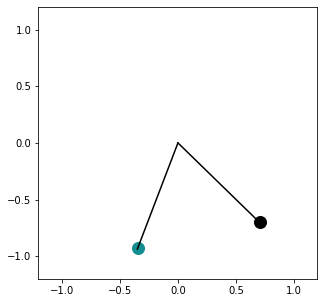

In [10]:
app = Application(dt=50)
furiko = Furiko()
app.add_figure('furiko', furiko.init_anim, furiko.update_anim)
app.mainloop()